In [1]:
pip install xpress networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import xpress as xp
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
xp.init("/Users/allanzea/Documents/FICO Xpress Config/xpauth.xpr")
xp.init()

In [4]:
#from google.colab import drive
#drive.mount("/content/drive")

In [5]:
# read the CSV file into a pandas DataFrame
def read_sudoku_csv(file_path):
  df = pd.read_csv(file_path, header = None)
  return df

In [6]:
# example .csv file corresponding to Sudoku puzzle
sudoku_file_path = "/Users/allanzea/Documents/TUB Thesis/Files/killer_sudoku_puzzle_example.csv"
sudoku_board = read_sudoku_csv(sudoku_file_path)

In [7]:
# define dictionary of killer cages to use
# Source: https://www.youtube.com/watch?v=M7H0mpeYW00&t=902s
boxes = [
    [[0, 1], [2, 11], [10, 19], [18]],
    [[3, 12, 21], [4, 5, 14], [13, 22]],
    [[6, 7, 8], [15, 24], [16, 17, 25, 26]],
    [[28, 29], [36, 37], [38, 47], [45, 46]],
    [[39, 48], [31, 40, 41, 49, 50]],
    [[34, 42, 43, 51], [35, 44]],
    [[63, 64]],
    [[57, 58], [59, 68], [66, 67], [75]],
    [[60, 61], [62, 71, 80], [69, 70, 79]]
]

In [8]:
class SudokuGraph:

  def __init__(self, board, boxes):
    self.board = board
    self.graph = None
    self.grid_size = len(board)
    self.boxes = boxes

    # construct Sudoku graph of order grid_size
    self.create_sudoku_graph()



  def create_sudoku_graph(self):
    graph = nx.Graph()
    n = self.grid_size

    # create nodes for cells
    for row in range(n):
      for col in range(n):
        value = self.board.iloc[row, col]
        graph.add_node((row, col), value = value)

    # add edges to connect cells within the same row and column
    for row in range(n):
      for col in range(n):
        for i in range(n):
          if i != col:
            graph.add_edge((row, col), (row, i))
          if i != row:
            graph.add_edge((row, col), (i, col))

    # calculate the box size
    box_size = int(n ** 0.5)

    # add edges for the boxs
    for x in range(0, n, box_size):
      for y in range(0, n, box_size):
        for i in range(box_size):
          for j in range(box_size):
            for k in range(box_size):
              for l in range(box_size):
                if (i, j) != (k, l):
                  graph.add_edge((x + i, y + j), (x + k, y + l))

    # remove self-loops from the graph
    graph.remove_edges_from(nx.selfloop_edges(graph))

    # print Sudoku board
    plt.figure(figsize = (5,5))
    plt.title("Sudoku graph\n(board view)")
    pos = {(x,y):(y,-x) for x,y in graph.nodes()}
    nx.draw(graph,
            pos = pos,
            node_color = "orange",
            edgecolors = "black",
            with_labels = False,
            node_size = 400)
    
    # print Sudoku graph
    plt.figure(figsize = (5,5))
    plt.title("Sudoku graph\n(full view)")
    nx.draw(graph, 
            pos = nx.circular_layout(graph),
            node_color = "orange",
            edgecolors = "black",
            node_size = 50)

    # replace labels with numbers
    mapping = {node : index for index, node in enumerate(graph.nodes())}
    graph = nx.relabel_nodes(graph, mapping)

    self.graph = graph


  
  def color(self):
    G = self.graph
    V, E = G.nodes, G.edges
    boxes = self.boxes

    # create a new problem instance
    p = xp.problem()

    # define bound H on the chromatic number
    n = self.grid_size
    H = n

    # define bound S_max on the cage sums
    S_max = n * (n + 1) // 2
    print("S_max: ", S_max)

    # create variable for each node and each potential color
    x = xp.vars(len(V), H, vartype = xp.binary, name = 'x')
    w = np.array([xp.var(vartype = xp.binary) for i in range(H)], dtype = xp.npvar)
    y = xp.vars(len(boxes), S_max, vartype = xp.binary, name = 'y')

    # add variables to the problem
    p.addVariable(x)
    p.addVariable(w)
    p.addVariable(y)

    # set the objective
    # p.setObjective(xp.Sum([w[i] for i in range(H)]), sense = xp.minimize)

    # add precoloring constraints
    for v in V:
        # i : initial color of cell
        i = V[v]["value"]
        if i != 0:
            # add precolored nodes to the problem
            p.addConstraint(x[v,i-1] == 1.0)

    # add assignment constraints
    c_1 = [xp.Sum([x[v,i] for i in range(H)]) == 1.0 for v in V]
    c_2 = [x[u,i] + x[v,i] <= w[i] for i in range(H) for u,v in E]
    # add symmetry-breaking constraints
    c_3 = [w[i] <= xp.Sum([x[v,i] for v in V]) for i in range(H)]
    c_4 = [w[i] <= w[i-1] for i in range(1, H)] 
    # add box killer constraints
    c_5 = [[[xp.Sum([x[v,i] for v in K]) <= w[i] for K in boxes[B]] for B in range(len(boxes))] for i in range(H)]
    c_6 = [[[xp.Sum([xp.Sum([x[v,i] * (i + 1) for i in range(H)]) for v in K]) == xp.Sum([y[B,s] * (s + 1) for s in range(S_max)])] 
             for K in boxes[B]] for B in range(len(boxes))]
    c_7 = [xp.Sum([y[B,s] for B in range(len(boxes))]) <= 1 for s in range(S_max)] 

    p.addConstraint(c_1)
    p.addConstraint(c_2)
    p.addConstraint(c_3)
    p.addConstraint(c_4)
    p.addConstraint(c_5)
    p.addConstraint(c_6)
    p.addConstraint(c_7)

    # optimize problem
    p.optimize()

    p.write("box_killer_prob", "lp")
    p.iisall()
    print("The problem has {0} IISs".format(p.attributes.numiis))

    # objective = p.getObjVal()
    solution = p.getSolution(x)
    problem_status = p.getProbStatusString()

    # turn solution into a coloring
    coloring = [-1 for v in V]

    chromatic_number = n

    for v in G.nodes:
      for i in range(chromatic_number):
        if p.getSolution(x[v,i]):
          coloring[v] = i + 1

    # print unsolved Sudoku board
    print("\n\nUNSOLVED:")
    self.print_board(self.board)

    # print colored Sudoku (solved) board
    print("\n\nSOLVED:")
    solved_board = np.array(coloring).reshape(self.grid_size, self.grid_size)
    self.print_board(solved_board)

    return coloring, solution, problem_status



  def get_max_degree(self):
    degrees = dict(self.graph.degree())
    print(degrees)
    max_degree = degrees[max(degrees, key = degrees.get)]

    self.plot_graph_degree_stats(self.graph)

    return max_degree
  


  @staticmethod
  def print_board(board):
    board_np = np.array(board)
    n = len(board_np)

    # determine box size for separating lines placement
    box_size = int(n ** 0.5)

    for row in range(n):
      if row % box_size == 0 and row != 0:
        print("- " * (n + box_size + 1))

      for col in range(n):
        if col % box_size == 0 and col != 0:
          print(" | ", end = " ")

        if col == n - 1:
          if board_np[row][col] == 0:
            print(".")
          else:
            print(board_np[row][col])
        else:
          if board_np[row][col] == 0:
            print("." + " ", end = "")
          else:
            print(str(board_np[row][col]) + " ", end = "")
  


  @staticmethod
  def plot_graph_degree_stats(graph):
    fig, ax1 = plt.subplots(figsize = (10, 2))
    ax1.plot(sorted((d for n, d in graph.degree()), reverse = True), 
             marker = "o", 
             color = "orange",
             markeredgecolor = "black")
    ax1.set_title("Degree distribution")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Vertex")
    plt.show()

Number of vertices:  81
Number of edges:  810


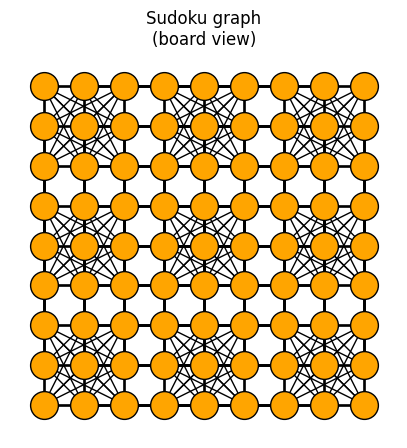

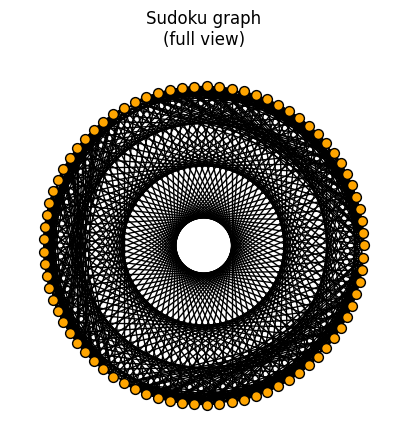

In [9]:
G_sudoku = SudokuGraph(sudoku_board, boxes)

print("Number of vertices: ", len(G_sudoku.graph.nodes))
print("Number of edges: ", len(G_sudoku.graph.edges))

{0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20, 16: 20, 17: 20, 18: 20, 19: 20, 20: 20, 21: 20, 22: 20, 23: 20, 24: 20, 25: 20, 26: 20, 27: 20, 28: 20, 29: 20, 30: 20, 31: 20, 32: 20, 33: 20, 34: 20, 35: 20, 36: 20, 37: 20, 38: 20, 39: 20, 40: 20, 41: 20, 42: 20, 43: 20, 44: 20, 45: 20, 46: 20, 47: 20, 48: 20, 49: 20, 50: 20, 51: 20, 52: 20, 53: 20, 54: 20, 55: 20, 56: 20, 57: 20, 58: 20, 59: 20, 60: 20, 61: 20, 62: 20, 63: 20, 64: 20, 65: 20, 66: 20, 67: 20, 68: 20, 69: 20, 70: 20, 71: 20, 72: 20, 73: 20, 74: 20, 75: 20, 76: 20, 77: 20, 78: 20, 79: 20, 80: 20}


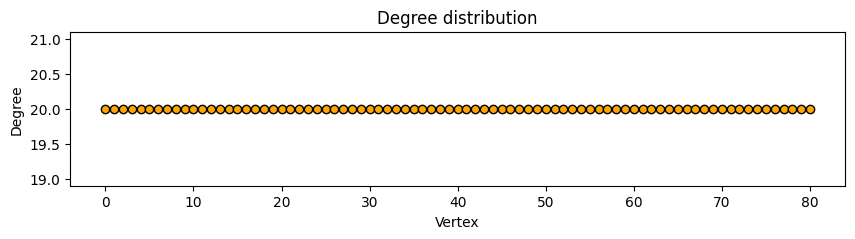

20

In [10]:
G_sudoku.get_max_degree()

In [11]:
coloring, solution, problem_status = G_sudoku.color()

S_max:  45
FICO Xpress v9.2.5, Hyper, solve started 19:01:53, May 15, 2024
Heap usage: 3508KB (peak 3508KB, 1703KB system)
Minimizing MILP noname using up to 10 threads and up to 32GB memory, with these control settings:
OUTPUTLOG = 1
Original problem has:
      7693 rows         1143 cols        26278 elements      1143 entities
Presolved problem has:
       381 rows          863 cols         4809 elements       863 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 3582KB (peak 7864KB, 1703KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  4.50e+01] / [ 6.25e-02,  1.12e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  Objective      [min,max] : [      0.0,       0.0] / [      0.0,       0.0]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usage below 30.3GB
Starting concurrent solve with dual (1 thread)

 Concur

In [12]:
print(coloring)

[7, 1, 5, 6, 8, 3, 9, 2, 4, 9, 2, 3, 4, 7, 1, 8, 6, 5, 8, 6, 4, 2, 5, 9, 7, 3, 1, 1, 4, 7, 5, 2, 6, 3, 8, 9, 6, 5, 9, 8, 3, 4, 2, 1, 7, 3, 8, 2, 9, 1, 7, 5, 4, 6, 2, 7, 8, 1, 6, 5, 4, 9, 3, 5, 9, 6, 3, 4, 2, 1, 7, 8, 4, 3, 1, 7, 9, 8, 6, 5, 2]


In [13]:
print(solution[0:5])

[[ 0.  0.  0. -0. -0. -0.  1. -0. -0.]
 [ 1. -0.  0. -0. -0. -0.  0. -0. -0.]
 [-0. -0. -0.  0.  1. -0.  0. -0. -0.]
 [-0. -0. -0. -0. -0.  1. -0. -0. -0.]
 [-0.  0. -0. -0. -0. -0. -0.  1. -0.]]


In [14]:
print(problem_status)

mip_optimal


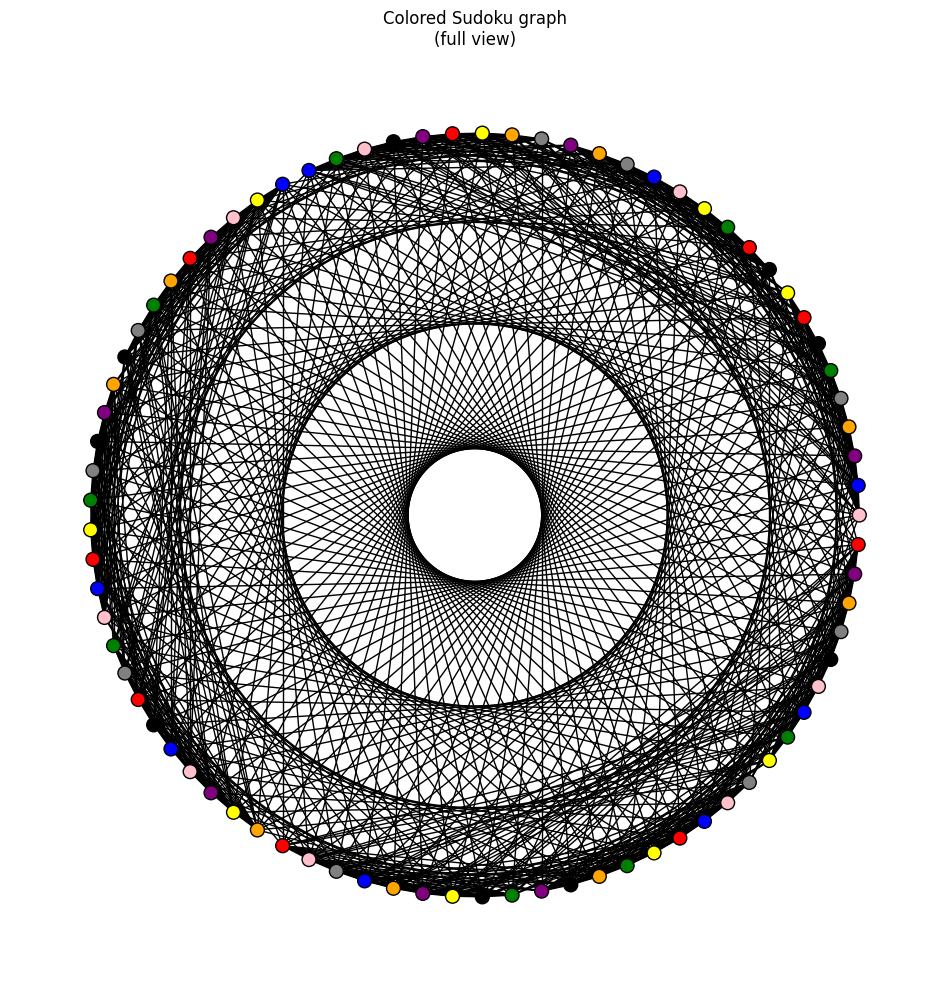

In [15]:
palette = ["blue", "red", "green", "yellow", "purple", "orange", "pink", "grey", "black"]
node_colors = [palette[coloring[i] - 1] for i in G_sudoku.graph.nodes]

plt.figure(figsize = (12,12))
plt.title("Colored Sudoku graph\n(full view)")
nx.draw(G_sudoku.graph,
        pos = nx.circular_layout(G_sudoku.graph),
        node_color = node_colors,
        edgecolors = "black",
        node_size = 100)